In [6]:
import os
import torch
import torchaudio
from matplotlib import pyplot as plt
from IPython.display import Audio, display, clear_output, HTML
import math
import numpy as np
import pandas as pd
import pickle
import time
import shutil
from cepstrum import cepstrum
import glob
import re
import umap
import umap.plot
from pylab import rcParams
import cufflinks as cf
import hvplot
import hvplot.pandas
cf.set_config_file(sharing='public',theme='ggplot',offline=True)

In [55]:
class Station:
    
    def __init__(self, name, thrshold):
        self.name = name
        self.thrshold = thrshold
        self.events = []
        
    def set_event(self, event):
        if (event.duration >= self.thrshold):
            self.events.append(event)

class Event:
    
    def __init__(self, name, wav_dir, station):
        self.name = name
        self.station = station
        self.kind = '' # it will be the original wav file name
        self.duration = 0.0
        self.power = 0.0
        self.calculator(name, wav_dir)
    
    def calculator(self, audio, wav_dir):
        self.kind_set(audio)
        self.audio_average_power(wav_dir)
    
    def audio_average_power(self, wav_dir):
         
        main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
        #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"

        wav_path = os.path.join(main + wav_dir, self.name)
        waveform, sample_rate = torchaudio.load(wav_path)
        num_channels, num_frames = waveform.shape
        
        if waveform.numpy().shape[1] != 0:
            
            ft_wf = np.fft.fft(waveform.numpy())/(math.sqrt(waveform.numpy().shape[1]))
            
            parseval_waveform = np.sum(waveform.numpy()**2)
            parseval_fourier_transform = np.sum(np.abs(ft_wf)**2)
            
            if (np.float32(round(parseval_waveform,1)) == np.float32(round(parseval_fourier_transform,1))):
                
                self.power = parseval_waveform
                
                duration = torch.arange(0, num_frames) / sample_rate
                self.duration = duration.numpy()[-1]
            
    def kind_set(self, audio):
        text = audio.split('_')
        self.kind = text[2]

def folders(wav_dir, station):
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    wav_noise_names = os.listdir(wav_dir + noise)
    wav_not_noise_names = os.listdir(wav_dir + not_noise)
    
    print(station.name, " -> In Noise folder")
    
    for w in wav_noise_names:
        station.set_event(Event(w, wav_dir + noise, station.name))
    
    print(station.name, " -> In Not Noise folder")
    
    for nn in wav_not_noise_names:
        station.set_event(Event(nn, wav_dir + not_noise, station.name))
    
    return station

def dataframer(stations):
    
    thrshold = 0.5
    data = []
    framer = []
    
    for s in stations:
        
        data.clear()
        
        for e in s.events:
            
            if e.duration >= thrshold:
                data.append([s.name, e.name, e.kind, e.duration, e.power])
        
        framer.append(pd.DataFrame(data.copy(), columns = ['station', 'audio', 'class', 'duration', 'power']))
    
    return framer

#returns a slice of dataframes!!
def _initiator(thrshold):
    
    stations = []
    fls = []

#     main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
#     wav_dir = '/home/kasparov/Documentos/20190114_vpoblete/20221019_Wasserstein/'
    
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")
    
    
    for f in fls:
        stations.append(Station(f.split("_")[8], thrshold))
    
    for s in stations:
        
        for f in fls:
            if(f.split("_")[8] == s.name):
                print("Working in: ", s.name)
                s = folders(f, s)
                break
            
    return stations, fls

def _writer(stations):
    
    filewriter = open("stations/stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _npzwriter(stations):
    
    filewriter = open("stations/npz_stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _reader(file):
    
    filereader = open("stations/" + file, "rb")
    stations = pickle.load(filereader)
    filereader.close()
    
    return stations

def _copier(stations, fls):
    
    main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    for s in stations:
        counter = 0
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter = counter + 1

                    if("ruido" in e.name):
                        item = main+f+noise+e.name
                        shutil.copy(item, main+"stations/"+noise)
                        break
                    else:
                        item = main+f+not_noise+e.name
                        shutil.copy(item, main+"stations/"+not_noise)
                        break
                        
def _npz_copier(stations, fls):
    
    main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    #main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    counter_noise = 0
    counter_event = 0
    for s in stations:
        counter = 0
        
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter += 1
                    if("ruido" in e.name):
                        item = main+f+noise
                        filename = item+e.name
                        newit = main + "stations/" + noise
                        setattr(e, 'kind', e.name)
                        cep_filename = cepstrum(filename)
                        setattr(e, 'name', 'noise'+str(counter_noise)+'.npz')
                        newfile = newit + getattr(e, 'name')
                        np.savez(newfile, cep_filename)
                        counter_noise += 1
                    
                        break
                        
                    else:
                        item = main+f+not_noise
                        filename = item+e.name
                        newit = main + "stations/" + not_noise
                        setattr(e, 'kind', e.name)
                        cep_filename = cepstrum(filename)
                        setattr(e, 'name', 'event'+str(counter_event)+'.npz')
                        newfile = newit + getattr(e,'name')
                        np.savez(newfile, cep_filename)
                        counter_event += 1
                        break
            
    return stations


def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
     (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def big_matrix():
    
#     npzfilespath =r"/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/stations/ruido/"  
    npzfilespath = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    
    os.chdir(npzfilespath)
    npfiles= glob.glob("*.npz")
    npfiles.sort(key=natural_keys)
    all_arrays = []
    #print(npfiles)
    
    for i, npfile in enumerate(npfiles):
        #print(npfile)
        X = np.load(os.path.join(npzfilespath, npfile))
        #print(X)
        #print(len(X['arr_0']))
        all_arrays.append(X['arr_0'])
    
    big_matrix = np.array(all_arrays)
    np.savez('big_matrix_noise',big_matrix)
    print(big_matrix.shape)
    
def categorizer(row):
    
    if (row['station'] == 'ronda1/' or row['station'] == 'ronda2/'):
        
        return 'capta_002'
    
    elif (row['station'] == 'ronda3/' or row['station'] == 'ronda6/'):
        
        return 'capta'
    
    elif (row['station'] == 'ronda4/'):
        
        return 'control_acustico'
    
    elif (row['station'] == 'ronda5/'):
        
        return 'mma'
    
    print('falla')
    
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1, figsize=(10,2))
    axes.plot(time_axis, waveform[0], linewidth=1, color='k')
    #axes.grid(True)
    figure.suptitle(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show(block=False)
    
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None, ylim=True):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(10,2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate, cmap='Greys')
        axes[c].set_yscale('log')
        
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        #axes[c].set_ylim(ylim)
        axes[c].set_ylim([500, 10000])
    figure.suptitle(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.show(block=False)

In [ ]:
start = time.time()

stations, fls = _initiator(0.5)

end = time.time()

print(round(end-start,1))

_writer(stations)

In [ ]:
stations = _reader('stations.fusa')

In [8]:
fls=[]
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")

In [ ]:
stations

In [ ]:
npz_station = _npz_copier(stations, fls)
_npzwriter(npz_station)

In [ ]:
df = dataframer(stations)

In [9]:
npz_stations = _reader('npz_stations.fusa')
df_npz = dataframer(npz_stations)
df_npz

[      station          audio  \
 0     ronda1/     noise0.npz   
 1     ronda1/     noise1.npz   
 2     ronda1/     noise2.npz   
 3     ronda1/     noise3.npz   
 4     ronda1/     noise4.npz   
 ...       ...            ...   
 1262  ronda1/  event1016.npz   
 1263  ronda1/  event1017.npz   
 1264  ronda1/  event1018.npz   
 1265  ronda1/  event1019.npz   
 1266  ronda1/  event1020.npz   
 
                                                  class   duration      power  
 0                  1653712794_1653712854_ruido_223.wav  13.647708   0.754834  
 1                  1653789034_1653789094_ruido_417.wav   2.769979   0.419892  
 2                  1653706209_1653706269_ruido_160.wav  27.045750   1.402200  
 3                 1655255968_1655256028_ruido_1248.wav   4.182500   0.074135  
 4                 1655063894_1655063954_ruido_1159.wav   1.474979   0.218602  
 ...                                                ...        ...        ...  
 1262  1655234087_1655234147_Camion_movimi

In [ ]:
big_matrix()

In [10]:
n_1 =50
m_1 =0.2

n_2 =40
m_2 =0.2

n_3 =30
m_3 =0.2

n_4 =40
m_4 =0.2

n_5 =50
m_5 =0.2

In [12]:
path_bm = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/stations/matrix/'
#path_bm = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/stations/matrix/"
noises = np.load(path_bm + 'big_matrix_noise.npz')
X = noises['arr_0']
embedding = umap.UMAP(n_neighbors = 50,
                        min_dist  = 0.8,
                        verbose = True,
                        metric='correlation').fit(X)

emb_filename = "stations/embedding.fusa"

pickle.dump(embedding, open(emb_filename, "wb"))

In [13]:
embedding = pickle.load(open(emb_filename, "rb"))

In [14]:
frame = [df_npz[0], df_npz[1], df_npz[2], df_npz[3], df_npz[4], df_npz[5]]
df = pd.concat(frame)
df['station_name'] = df.apply(lambda row: categorizer(row), axis=1)
df.sort_values(by=['audio'])
df

,station,audio,class,duration,power,station_name
0,ronda1/,noise0.npz,1653712794_1653712854_ruido_223.wav,13.647708,0.754834,capta_002
1,ronda1/,noise1.npz,1653789034_1653789094_ruido_417.wav,2.769979,0.419892,capta_002
2,ronda1/,noise2.npz,1653706209_1653706269_ruido_160.wav,27.045750,1.402200,capta_002
3,ronda1/,noise3.npz,1655255968_1655256028_ruido_1248.wav,4.182500,0.074135,capta_002
4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002
...,...,...,...,...,...,...
1998,ronda6/,event7674.npz,62e39b767a2acbde063ecf57_Multitud_1166.wav,10.960229,153.902313,capta
1999,ronda6/,event7675.npz,62e4c87f7a2acbde063ed7a9_Camion_movimiento_202...,11.274271,101.971397,capta
2000,ronda6/,event7676.npz,62e3d6127a2acbde063ed23a_Camion_1479.wav,29.999979,494.117554,capta
2001,ronda6/,event7677.npz,62e23bd47a2acbde063eca5b_Automovil_movimiento_...,18.013229,24.495485,capta


In [15]:
data = df[df['audio'].str.contains('noise')]
data

,station,audio,class,duration,power,station_name
0,ronda1/,noise0.npz,1653712794_1653712854_ruido_223.wav,13.647708,0.754834,capta_002
1,ronda1/,noise1.npz,1653789034_1653789094_ruido_417.wav,2.769979,0.419892,capta_002
2,ronda1/,noise2.npz,1653706209_1653706269_ruido_160.wav,27.045750,1.402200,capta_002
3,ronda1/,noise3.npz,1655255968_1655256028_ruido_1248.wav,4.182500,0.074135,capta_002
4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002
...,...,...,...,...,...,...
192,ronda6/,noise1789.npz,62e4bf687a2acbde063ed68c_ruido_1965.wav,12.370438,0.873634,capta
193,ronda6/,noise1790.npz,62e3673c7a2acbde063ecb48_ruido_724.wav,0.794667,0.466743,capta
194,ronda6/,noise1791.npz,62e2175c7a2acbde063ec764_ruido_321.wav,0.582500,0.029089,capta
195,ronda6/,noise1792.npz,62e4b7147a2acbde063ed579_ruido_1864.wav,9.151271,1.930381,capta


In [16]:
embedding

UMAP(angular_rp_forest=True, metric='correlation', min_dist=0.8, n_neighbors=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

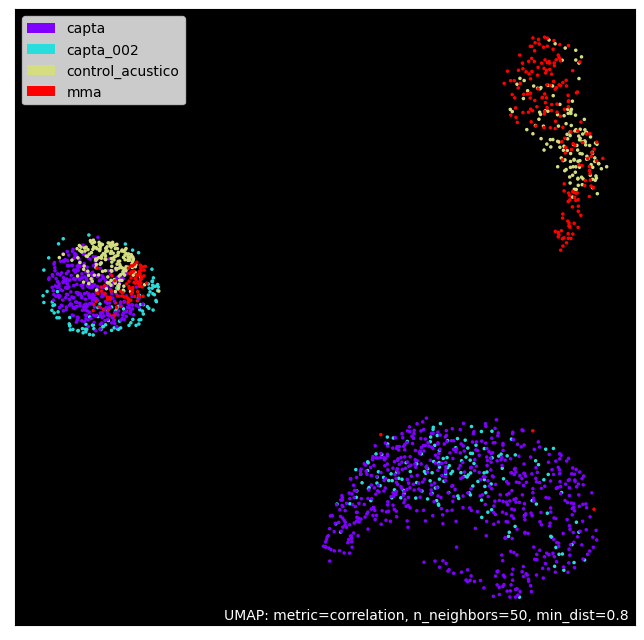

In [17]:
umap.plot.points(embedding, labels = data.station_name,theme='fire')
umap.plot.plt.show()

In [18]:
data["Embedding 0"] = embedding.embedding_[:, 0]
data["Embedding 1"] = embedding.embedding_[:, 1]

<AxesSubplot:xlabel='Embedding 0', ylabel='Embedding 1'>

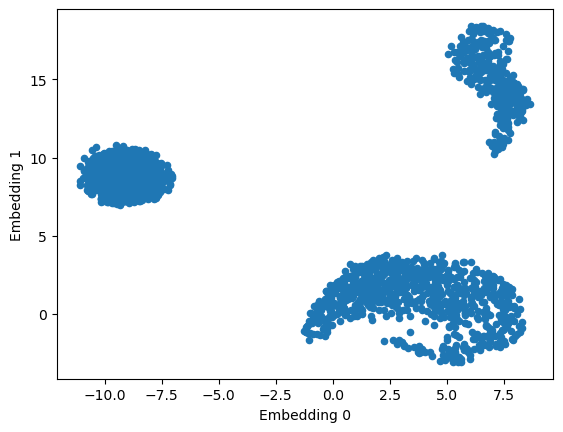

In [19]:
data.plot.scatter(x = "Embedding 0", y = "Embedding 1")

In [20]:
data.hvplot(kind='scatter', x = 'Embedding 0', y = 'Embedding 1', by = 'station_name')

:NdOverlay   [station_name]
   :Scatter   [Embedding 0]   (Embedding 1)

In [22]:
miniball = data[data['Embedding 0'] < -5]

miniball.to_csv('stations/UMAP_df_separation/miniball.csv') # checkpoints para no tener que correr todo

miniball

,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002,-7.078475,8.694945
10,ronda1/,noise10.npz,1653787701_1653787761_ruido_366.wav,0.869979,0.041000,capta_002,-7.137180,8.317614
11,ronda1/,noise11.npz,1653981393_16539814531_ruido_578.wav,0.969521,0.030351,capta_002,-8.983613,7.313937
12,ronda1/,noise12.npz,1653981393_16539814531_ruido_574.wav,1.258250,0.022924,capta_002,-7.190462,8.536841
14,ronda1/,noise14.npz,1654238167_16542382271_ruido_724.wav,1.349979,0.069800,capta_002,-7.666259,7.582621
...,...,...,...,...,...,...,...,...
181,ronda6/,noise1778.npz,62df75947a2acbde063ebe2e_ruido_306.wav,0.562292,0.280692,capta,-7.963650,7.989766
187,ronda6/,noise1784.npz,62e380727a2acbde063ecd51_ruido_939.wav,0.755667,13.400764,capta,-7.960124,8.144318
191,ronda6/,noise1788.npz,62e21bc17a2acbde063ec7be_ruido_369.wav,0.528938,0.121111,capta,-8.175775,7.701985
193,ronda6/,noise1790.npz,62e3673c7a2acbde063ecb48_ruido_724.wav,0.794667,0.466743,capta,-7.917758,7.768628


In [23]:
upper = data[data['Embedding 0'] > -5]
upper = upper[upper['Embedding 1'] > 10]

upper.to_csv('stations/UMAP_df_separation/upper.csv')

upper

,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
5,ronda4/,noise1019.npz,EM2030-00749-2022-06-02T09-57-00-070dB_ruido_7...,2.330083,1.327942,control_acustico,7.571877,17.530857
7,ronda4/,noise1021.npz,EM2030-00750-2022-06-04T16-50-55-063dB_ruido_8...,3.565104,0.141079,control_acustico,7.902381,14.389242
8,ronda4/,noise1022.npz,EM2030-00750-2022-05-31T15-43-21-067dB_ruido_7...,3.874156,0.765521,control_acustico,7.884919,14.430006
17,ronda4/,noise1031.npz,EM2030-00749-2022-07-03T21-45-39-057dB_ruido_6...,2.760042,0.091752,control_acustico,7.720119,13.947270
19,ronda4/,noise1033.npz,EM2030-00749-2022-07-03T05-40-44-072dB_ruido_6...,2.482646,0.045760,control_acustico,7.610083,14.258318
...,...,...,...,...,...,...,...,...
264,ronda5/,noise1588.npz,EM2030-00849-2021-07-27T05-28-09-065dB_ruido_1...,4.348771,0.091779,mma,7.529770,12.269506
266,ronda5/,noise1590.npz,EM2030-00628-2018-12-31T13-50-46-082dB_ruido_7...,1.733688,9.364539,mma,7.235136,16.753725
267,ronda5/,noise1591.npz,EM2030-00628-2019-01-22T15-29-33-088dB_ruido_1...,2.815531,3.883837,mma,6.053322,15.591783
269,ronda5/,noise1593.npz,EM2030-00849-2021-06-26T23-19-00-067dB_ruido_1...,6.777031,0.742351,mma,7.453535,11.904997


In [24]:
lower = data[data['Embedding 0'] > -5]
lower = lower[lower['Embedding 1'] < 10]

lower.to_csv('stations/UMAP_df_separation/lower.csv')


lower

,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
0,ronda1/,noise0.npz,1653712794_1653712854_ruido_223.wav,13.647708,0.754834,capta_002,2.794849,1.468501
1,ronda1/,noise1.npz,1653789034_1653789094_ruido_417.wav,2.769979,0.419892,capta_002,0.279120,1.795860
2,ronda1/,noise2.npz,1653706209_1653706269_ruido_160.wav,27.045750,1.402200,capta_002,4.490968,0.201921
3,ronda1/,noise3.npz,1655255968_1655256028_ruido_1248.wav,4.182500,0.074135,capta_002,1.440442,0.753262
5,ronda1/,noise5.npz,1654220421_1654220481_ruido_709.wav,6.749979,0.995816,capta_002,0.980861,2.813975
...,...,...,...,...,...,...,...,...
189,ronda6/,noise1786.npz,62e21dcb7a2acbde063ec7e7_ruido_401.wav,8.758708,0.135892,capta,-0.277729,-0.931653
190,ronda6/,noise1787.npz,62e218347a2acbde063ec774_ruido_327.wav,8.566688,0.156355,capta,-0.544465,-1.360761
192,ronda6/,noise1789.npz,62e4bf687a2acbde063ed68c_ruido_1965.wav,12.370438,0.873634,capta,4.530090,2.527080
195,ronda6/,noise1792.npz,62e4b7147a2acbde063ed579_ruido_1864.wav,9.151271,1.930381,capta,5.659592,2.705739


In [77]:
pd.set_option('display.max_rows', None)
station_audio_to_listen = miniball['station']
station_audio_to_listen

4      ronda1/
10     ronda1/
11     ronda1/
12     ronda1/
14     ronda1/
15     ronda1/
22     ronda1/
23     ronda1/
24     ronda1/
25     ronda1/
29     ronda1/
30     ronda1/
32     ronda1/
35     ronda1/
41     ronda1/
44     ronda1/
49     ronda1/
52     ronda1/
55     ronda1/
58     ronda1/
59     ronda1/
64     ronda1/
65     ronda1/
67     ronda1/
68     ronda1/
69     ronda1/
71     ronda1/
72     ronda1/
73     ronda1/
74     ronda1/
75     ronda1/
76     ronda1/
80     ronda1/
81     ronda1/
82     ronda1/
84     ronda1/
85     ronda1/
87     ronda1/
90     ronda1/
92     ronda1/
94     ronda1/
95     ronda1/
96     ronda1/
102    ronda1/
107    ronda1/
110    ronda1/
111    ronda1/
112    ronda1/
118    ronda1/
121    ronda1/
125    ronda1/
128    ronda1/
130    ronda1/
131    ronda1/
133    ronda1/
134    ronda1/
135    ronda1/
136    ronda1/
137    ronda1/
138    ronda1/
142    ronda1/
149    ronda1/
151    ronda1/
152    ronda1/
155    ronda1/
158    ronda1/
165    ron

In [81]:
miniball

,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002,-7.078475,8.694945
10,ronda1/,noise10.npz,1653787701_1653787761_ruido_366.wav,0.869979,0.041000,capta_002,-7.137180,8.317614
11,ronda1/,noise11.npz,1653981393_16539814531_ruido_578.wav,0.969521,0.030351,capta_002,-8.983613,7.313937
12,ronda1/,noise12.npz,1653981393_16539814531_ruido_574.wav,1.258250,0.022924,capta_002,-7.190462,8.536841
14,ronda1/,noise14.npz,1654238167_16542382271_ruido_724.wav,1.349979,0.069800,capta_002,-7.666259,7.582621
15,ronda1/,noise15.npz,1655030626_1655030686_ruido_1088.wav,0.559958,0.038051,capta_002,-7.242273,8.571186
22,ronda1/,noise22.npz,1655030626_1655030686_ruido_1092.wav,0.846625,0.181172,capta_002,-7.344143,8.646460
23,ronda1/,noise23.npz,1654238167_16542382271_ruido_742.wav,1.094958,0.053150,capta_002,-7.271777,9.042994
24,ronda1/,noise24.npz,1653787701_1653787761_ruido_376.wav,0.639979,0.016448,capta_002,-10.782118,7.939058
25,ronda1/,noise25.npz,1655234087_1655234147_ruido_1200.wav,0.874146,0.196036,capta_002,-7.267581,8.785480


In [82]:
data_miniball = miniball.reset_index()
data_miniball

,index,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
0,4,ronda1/,noise4.npz,1655063894_1655063954_ruido_1159.wav,1.474979,0.218602,capta_002,-7.078475,8.694945
1,10,ronda1/,noise10.npz,1653787701_1653787761_ruido_366.wav,0.869979,0.041000,capta_002,-7.137180,8.317614
2,11,ronda1/,noise11.npz,1653981393_16539814531_ruido_578.wav,0.969521,0.030351,capta_002,-8.983613,7.313937
3,12,ronda1/,noise12.npz,1653981393_16539814531_ruido_574.wav,1.258250,0.022924,capta_002,-7.190462,8.536841
4,14,ronda1/,noise14.npz,1654238167_16542382271_ruido_724.wav,1.349979,0.069800,capta_002,-7.666259,7.582621
5,15,ronda1/,noise15.npz,1655030626_1655030686_ruido_1088.wav,0.559958,0.038051,capta_002,-7.242273,8.571186
6,22,ronda1/,noise22.npz,1655030626_1655030686_ruido_1092.wav,0.846625,0.181172,capta_002,-7.344143,8.646460
7,23,ronda1/,noise23.npz,1654238167_16542382271_ruido_742.wav,1.094958,0.053150,capta_002,-7.271777,9.042994
8,24,ronda1/,noise24.npz,1653787701_1653787761_ruido_376.wav,0.639979,0.016448,capta_002,-10.782118,7.939058
9,25,ronda1/,noise25.npz,1655234087_1655234147_ruido_1200.wav,0.874146,0.196036,capta_002,-7.267581,8.785480


In [83]:
data_miniball['station'].loc[0]

'ronda1/'

In [80]:
pd.set_option('display.max_rows', None)
audio_listen_to = miniball['class']
audio_listen_to.reset_index()
audio_listen_to

4                   1655063894_1655063954_ruido_1159.wav
10                   1653787701_1653787761_ruido_366.wav
11                  1653981393_16539814531_ruido_578.wav
12                  1653981393_16539814531_ruido_574.wav
14                  1654238167_16542382271_ruido_724.wav
15                  1655030626_1655030686_ruido_1088.wav
22                  1655030626_1655030686_ruido_1092.wav
23                  1654238167_16542382271_ruido_742.wav
24                   1653787701_1653787761_ruido_376.wav
25                  1655234087_1655234147_ruido_1200.wav
29                  1653981393_16539814531_ruido_586.wav
30                  1654238167_16542382271_ruido_728.wav
32                   1653872481_1653872541_ruido_526.wav
35                  1654270595_16542706551_ruido_846.wav
41                   1654909819_1654909879_ruido_991.wav
44                  1654270110_16542701701_ruido_813.wav
49                   1654271021_1654271081_ruido_905.wav
52                  1653981393_

In [71]:
station_audio_to_listen.loc[10].iat[0]

4      ronda1/
10     ronda1/
11     ronda1/
12     ronda1/
14     ronda1/
15     ronda1/
22     ronda1/
23     ronda1/
24     ronda1/
25     ronda1/
29     ronda1/
30     ronda1/
32     ronda1/
35     ronda1/
41     ronda1/
44     ronda1/
49     ronda1/
52     ronda1/
55     ronda1/
58     ronda1/
59     ronda1/
64     ronda1/
65     ronda1/
67     ronda1/
68     ronda1/
69     ronda1/
71     ronda1/
72     ronda1/
73     ronda1/
74     ronda1/
75     ronda1/
76     ronda1/
80     ronda1/
81     ronda1/
82     ronda1/
84     ronda1/
85     ronda1/
87     ronda1/
90     ronda1/
92     ronda1/
94     ronda1/
95     ronda1/
96     ronda1/
102    ronda1/
107    ronda1/
110    ronda1/
111    ronda1/
112    ronda1/
118    ronda1/
121    ronda1/
125    ronda1/
128    ronda1/
130    ronda1/
131    ronda1/
133    ronda1/
134    ronda1/
135    ronda1/
136    ronda1/
137    ronda1/
138    ronda1/
142    ronda1/
149    ronda1/
151    ronda1/
152    ronda1/
155    ronda1/
158    ronda1/
165    ron

In [92]:
data_miniball.loc[1].iat[3]

'1653787701_1653787761_ruido_366.wav'

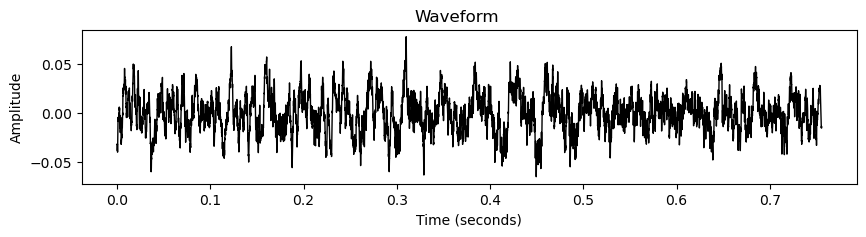

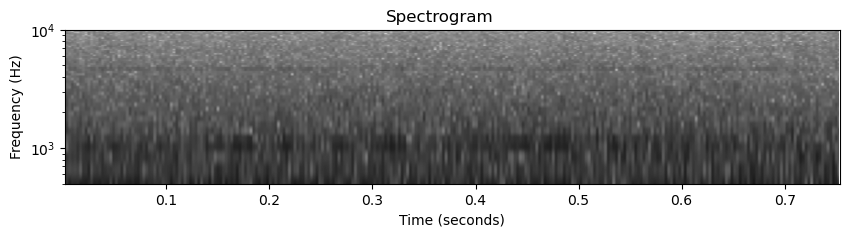

In [102]:
a = 695
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_miniball['station'].loc[a] + 'ruido/'
wav_file = main + data_miniball.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [97]:
data_upper = upper.reset_index()
data_upper 

,index,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
0,5,ronda4/,noise1019.npz,EM2030-00749-2022-06-02T09-57-00-070dB_ruido_7...,2.330083,1.327942,control_acustico,7.571877,17.530857
1,7,ronda4/,noise1021.npz,EM2030-00750-2022-06-04T16-50-55-063dB_ruido_8...,3.565104,0.141079,control_acustico,7.902381,14.389242
2,8,ronda4/,noise1022.npz,EM2030-00750-2022-05-31T15-43-21-067dB_ruido_7...,3.874156,0.765521,control_acustico,7.884919,14.430006
3,17,ronda4/,noise1031.npz,EM2030-00749-2022-07-03T21-45-39-057dB_ruido_6...,2.760042,0.091752,control_acustico,7.720119,13.947270
4,19,ronda4/,noise1033.npz,EM2030-00749-2022-07-03T05-40-44-072dB_ruido_6...,2.482646,0.045760,control_acustico,7.610083,14.258318
5,22,ronda4/,noise1036.npz,EM2030-00750-2022-06-16T14-22-35-057dB_ruido_1...,1.786896,0.116190,control_acustico,7.727480,14.876214
6,23,ronda4/,noise1037.npz,EM2030-00750-2022-06-02T16-11-17-064dB_ruido_7...,1.984552,1.465698,control_acustico,6.321016,16.432505
7,26,ronda4/,noise1040.npz,EM2030-00749-2022-06-13T14-15-23-068dB_ruido_2...,4.516125,2.213531,control_acustico,6.964432,14.999624
8,27,ronda4/,noise1041.npz,EM2030-00750-2022-06-13T13-59-18-067dB_ruido_1...,2.593802,0.242569,control_acustico,7.797905,12.753179
9,28,ronda4/,noise1042.npz,EM2030-00750-2022-07-05T15-00-35-058dB_ruido_1...,2.127875,0.155631,control_acustico,7.417990,15.639361


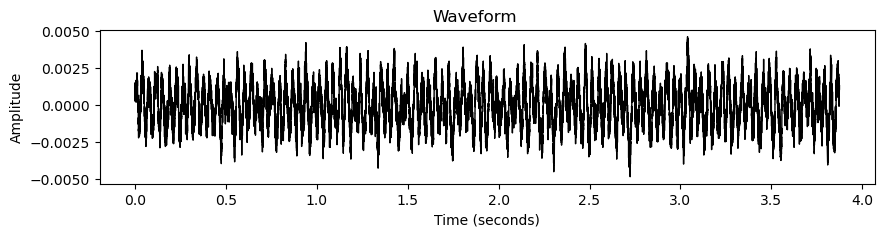

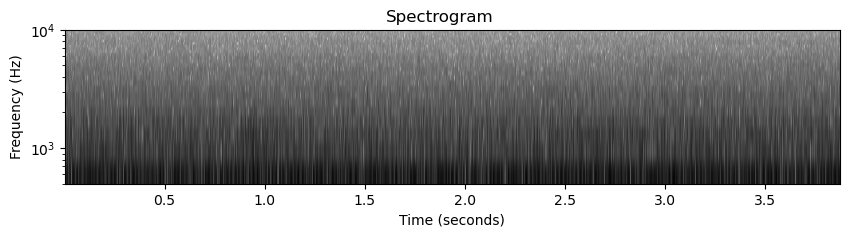

In [101]:
a = 2
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_upper['station'].loc[a] + 'ruido/'
wav_file = main + data_upper.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)

In [103]:
data_lower = lower.reset_index()
data_lower 

,index,station,audio,class,duration,power,station_name,Embedding 0,Embedding 1
0,0,ronda1/,noise0.npz,1653712794_1653712854_ruido_223.wav,13.647708,0.754834,capta_002,2.794849,1.468501
1,1,ronda1/,noise1.npz,1653789034_1653789094_ruido_417.wav,2.769979,0.419892,capta_002,0.279120,1.795860
2,2,ronda1/,noise2.npz,1653706209_1653706269_ruido_160.wav,27.045750,1.402200,capta_002,4.490968,0.201921
3,3,ronda1/,noise3.npz,1655255968_1655256028_ruido_1248.wav,4.182500,0.074135,capta_002,1.440442,0.753262
4,5,ronda1/,noise5.npz,1654220421_1654220481_ruido_709.wav,6.749979,0.995816,capta_002,0.980861,2.813975
5,6,ronda1/,noise6.npz,1653792853_1653792913_ruido_457.wav,1.599979,0.161079,capta_002,2.591969,2.143573
6,7,ronda1/,noise7.npz,1653709302_1653709362_ruido_185.wav,2.662937,0.079253,capta_002,2.758865,0.510822
7,8,ronda1/,noise8.npz,1653709302_1653709362_ruido_193.wav,1.830771,0.050816,capta_002,4.277450,0.003275
8,9,ronda1/,noise9.npz,1654985740_1654985800_ruido_1029.wav,5.799979,2.116780,capta_002,7.073621,0.955183
9,13,ronda1/,noise13.npz,1653709302_1653709362_ruido_187.wav,3.079042,0.087355,capta_002,2.768218,0.467647


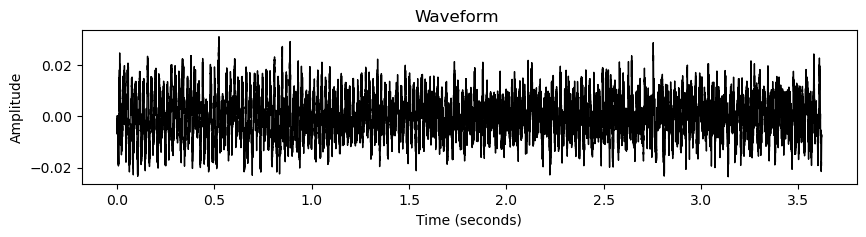

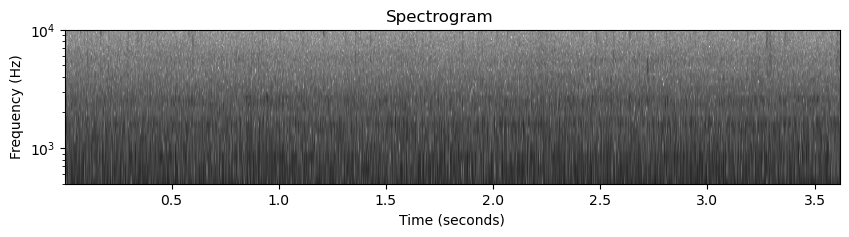

In [107]:
a = 22
main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/' + data_lower['station'].loc[a] + 'ruido/'
wav_file = main + data_lower.loc[a].iat[3]
waveform, sample_rate = torchaudio.load(wav_file)

plot_waveform(waveform, sample_rate, title="Waveform")
plot_specgram(waveform, sample_rate)
Audio(waveform.numpy()[0], rate=sample_rate)